# Step 1. 모듈 import & 데이터 로드

In [1]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# 주피터에서 high-resolution 이미지를 얻고자 할 때 사용.
# retina display가 없으면 사용 안해도 됨.
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

In [3]:
with open('korean-english-park.train.en', 'r', encoding='UTF8') as f:
    eng_raw = f.read().splitlines()
    
print('data size: ', len(eng_raw))
print('Example: ', eng_raw[20])

data size:  94123
Example:  Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.


In [4]:
with open('korean-english-park.train.ko', 'r', encoding='UTF8') as f:
    ko_raw = f.read().splitlines()
    
print('data size: ', len(ko_raw))
print('Example: ', ko_raw[20])

data size:  94123
Example:  북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.


# Step 2. 데이터 정제


### (1) set 활용해 중복 데이터 제거 (병렬 쌍 유지되도록)

In [5]:
def remove_duplicates(korean_texts, english_texts):
    cleaned_corpus_ko = []
    cleaned_corpus_eng = []
    seen_pairs = set()
    
    for ko, eng in zip(korean_texts, english_texts):
        pair = (ko, eng)
        if pair not in seen_pairs:
            cleaned_corpus_ko.append(ko)
            cleaned_corpus_eng.append(eng)
            seen_pairs.add(pair)
            
    return cleaned_corpus_ko, cleaned_corpus_eng

In [6]:
cleaned_corpus_ko, cleaned_corpus_eng = remove_duplicates(ko_raw, eng_raw)

In [7]:
print('eng data size: ', len(cleaned_corpus_eng))
print('eng Example: ', cleaned_corpus_eng[70000])
print('ko data size: ', len(cleaned_corpus_ko))
print('ko Example: ', cleaned_corpus_ko[70000])

eng data size:  78968
eng Example:  Abu Hamza al-Muhajir is ""knowledgeable"" and has a history of fighting a holy war, said an internet message on a site used by Islamic militants.
ko data size:  78968
ko Example:  이슬람 무장 단체 웹사이트를 통해 발표한 성명에따르면 아부 함자 알 무하지르는 지식이 풍부하고 성전聖戰(지하드) 경험이 많다.


__총 15,155개 중복 데이터가 삭제되었으며 데이터 쌍이 잘 유지되고 있음을 예시 텍스트를 통해 확인함__

In [8]:
def unique(l):
    if len(l) == len(set(l)):
        print("The List is Unique!")
        return True
    else:
        print("The List is Not Unique! The amount of duplicated data is {}".format(len(l)-len(set(l))))
        return False


In [9]:
unique(cleaned_corpus_ko)
unique(cleaned_corpus_eng)

The List is Not Unique! The amount of duplicated data is 1377
The List is Not Unique! The amount of duplicated data is 3370


False

__그러나, 각 데이터의 중복 여부를 확인해 봤을 때 한국어 데이터는 1377개, 영어 데이터는 3370개의 중복 문장이 존재함.__

dataframe으로 만들어서 확인해보자.

In [10]:
import pandas as pd

df = pd.DataFrame({'Korean': cleaned_corpus_ko, 'English': cleaned_corpus_eng})

In [11]:
duplicates = df.duplicated(subset=['Korean'], keep=False) # keep=False 모든 중복 항목 유지

# Filter the DataFrame to get the duplicate rows
duplicate_rows = df[duplicates]

# Print the duplicate rows
print(duplicate_rows)
print('한국어 데이터에서 전체 중복데이터 개수 : ',len(duplicate_rows))

                                                  Korean  \
27                                                  어휘 :   
30                                                  어휘 :   
282                                                 어휘 :   
1456                                                어휘 :   
2226                                                어휘 :   
...                                                  ...   
78739                                       원문 & 독해설명 인쇄   
78869                                           TOEIC 독해   
78895  Bush hails ´major shift´ in Iraq 부시, 이라크에 ‘중대한...   
78938                                      AP 라디오 뉴스입니다.   
78943                                     저장된 검색어가 없습니다.   

                                                 English  
27     The Geneva-based commission, in its annual stu...  
30     Postal Service - whose postmaster told a Senat...  
282    the United States will take every measure agai...  
1456   aid groups set up freshwater tanks t

* 한국어 데이터에는 번역문이 아닌 글귀가 더러 존재함 (어휘 :, 원문 & 독해설명 인쇄, TOEIC 독해, 등등)
* 해당 행은 모두 삭제.

In [12]:
def extract_rows_by_pattern(df, pattern):
    mask = df['Korean'].str.contains(pattern, regex=True)
    extracted_rows = df[mask]
    extracted_rows_indices = df[mask].index
    return extracted_rows, extracted_rows_indices

In [13]:
extracted_rows, extracted_rows_indices = extract_rows_by_pattern(df, pattern='어휘 :|TOEIC 독해|번역 :|저장된 검색어|뉴스입니다.|국어사전|일어사전')
df.drop(extracted_rows_indices, inplace=True)

In [14]:
duplicates = df.duplicated(subset=['Korean'], keep=False) # keep=False 모든 중복 항목 유지

duplicate_rows = df[duplicates]

print('한국어 데이터에서 전체 중복데이터 개수 : ',len(duplicate_rows))

한국어 데이터에서 전체 중복데이터 개수 :  1660


In [15]:
# 번역없이 '국제원자력기구' 라고만 쓰여있는 행 삭제
df.drop([76096, 78670], inplace=True)

In [16]:
duplicates = df.duplicated(subset=['Korean'], keep=False) # keep=False 모든 중복 항목 유지

duplicate_rows = df[duplicates]

print('한국어 데이터에서 전체 중복데이터 개수 : ',len(duplicate_rows))

한국어 데이터에서 전체 중복데이터 개수 :  1658


* 한국어 컬럼에서 중복된 데이터들 중 한개씩만 남기고 나머지는 삭제

In [17]:
def remove_duplicates_keep_one(df, column_name):
    df_unique = df.drop_duplicates(subset=column_name)
    return df_unique

df_ko_unique = remove_duplicates_keep_one(df, column_name='Korean')

In [18]:
unique(df_ko_unique['Korean'])

The List is Unique!


True

* 한국어 중복 데이터는 모두 처리됨.

In [19]:
def remove_duplicates_keep_one(df, column_name):
    df_unique = df.drop_duplicates(subset=column_name)
    return df_unique

cleaned_corpus = remove_duplicates_keep_one(df_ko_unique, column_name='English')

In [20]:
unique(cleaned_corpus['Korean'])
unique(cleaned_corpus['English'])

The List is Unique!
The List is Unique!


True

* 영어 중복 데이터도 모두 처리 완료

In [21]:
cleaned_corpus.head(3)

,Korean,English
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?""","Much of personal computing is about ""can you t..."
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...
2,그러나 이것은 또한 책상도 필요로 하지 않는다.,"Like all optical mice, But it also doesn't nee..."


In [22]:
cleaned_corpus.shape

(74816, 2)

* 중복 데이터를 모두 처리하여 최종적으로 94123개 중 __74816개의 데이터 쌍__ 이 준비되었음.

### (2) 정규식 이용하여 데이터 전처리

* 한글에 적용할 수 있는 정규식 포함한 preprocess_sentence() 함수 정의
* 타겟 언어인 영문에 \<start> 토큰과 \<end> 토큰 추가
* 영문 데이터는 split() 함수 이용하여 토큰화
* 한글 데이터는 KoNLPy의 mecab 클래스 이용하여 토큰화
* 토큰 길이가 40 이하인 데이터 선별하여 eng_corpus, kor_corpus 각각 구축

In [23]:
def preprocess_sentence(sentence, strip=False, s_token=False, e_token=False):
    
    if strip:
        sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence) # r" \1 " >> 캡처된 구두점 주위에 공백 추가
    sentence = re.sub(r'[" "]+', " ", sentence) # 연속된 여러 공백을 하나의 공백으로 바꿉
    sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z?.!,]+", " ", sentence)

    if strip:
        sentence = sentence.strip() # 앞뒤 공백을 제거

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

In [24]:
cleaned_corpus['English'] = cleaned_corpus['English'].apply(lambda x : preprocess_sentence(x, strip=True, s_token=True, e_token=True))
cleaned_corpus['Korean'] = cleaned_corpus['Korean'].apply(lambda x : preprocess_sentence(x, strip=False, s_token=False, e_token=False))

/tmp/ipykernel_261/3101686308.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_corpus['English'] = cleaned_corpus['English'].apply(lambda x : preprocess_sentence(x, strip=True, s_token=True, e_token=True))
/tmp/ipykernel_261/3101686308.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_corpus['Korean'] = cleaned_corpus['Korean'].apply(lambda x : preprocess_sentence(x, strip=False, s_token=False, e_token=False))


__한문, 영문 데이터 토큰화 및 max_length 40 초과인 행 삭제__

In [25]:
from konlpy.tag import Mecab

tokenizer = Mecab()
cleaned_corpus['Korean'] = cleaned_corpus['Korean'].apply(lambda x : tokenizer.morphs(x))

/tmp/ipykernel_261/1841466105.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_corpus['Korean'] = cleaned_corpus['Korean'].apply(lambda x : tokenizer.morphs(x))


In [26]:
cleaned_corpus['English'] = cleaned_corpus['English'].apply(lambda x: x.split() if isinstance(x, str) else x)
cleaned_corpus

/tmp/ipykernel_261/4054353713.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_corpus['English'] = cleaned_corpus['English'].apply(lambda x: x.split() if isinstance(x, str) else x)


,Korean,English
0,"[개인, 용, 컴퓨터, 사용, 의, 상당, 부분, 은, 이것, 보다, 뛰어날, 수,...","[<start>, much, of, personal, computing, is, a..."
1,"[모든, 광, 마우스, 와, 마찬가지, 로, 이, 광, 마우스, 도, 책상, 위, ...","[<start>, so, a, mention, a, few, weeks, ago, ..."
2,"[그러나, 이것, 은, 또한, 책상, 도, 필요, 로, 하, 지, 않, 는다, .]","[<start>, like, all, optical, mice, ,, but, it..."
3,"[., 달러, 하, 는, 이, 최첨단, 무선, 광, 마우스, 는, 허공, 에서, 팔...","[<start>, uses, gyroscopic, sensors, to, contr..."
4,"[정보, 관리, 들, 은, 동남, 아시아, 에서, 의, 선박, 들, 에, 대한, 많...","[<start>, intelligence, officials, have, revea..."
...,...,...
78963,"[우리, 는, 월, 일, 김승연, 회장, 과, 그, 의, 아들, 이, 보복, 폭행,...","[<start>, we, are, hoping, to, seize, material..."
78964,"[월요일, 술집, 종업원, 명, 은, 김, 회장, 과, 아들, 에게, 폭행, 을, ...","[<start>, on, monday, ,, police, secured, stat..."
78965,"[그러나, 불, 충분, 한, 증거, 확보, 로, 수사, 에, 어려움, 이, 있, 다...","[<start>, but, the, lack, of, material, eviden..."
78966,"[김, 회장, 과, 그, 의, 아들, 은, 보복, 폭행, 혐의, 를, 강력히, 부인...","[<start>, kim, and, his, son, both, deny, the,..."


In [27]:
# 각 텍스트의 문장길이 정보를 담은 리스트 생성
num_tokens = [len(tokens) for tokens in cleaned_corpus['English']]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차 확인
print('문장길이 평균: ', np.mean(num_tokens))
print('문장길이 최대: ', np.max(num_tokens))
print('문장길이 표준편차: ', np.std(num_tokens))

# 최대 길이를 위 sentencepiece와 동일한 60 으로 한다면, 몇 %의 데이터가 포함되는지 확인
maxlen = 40
print('pad_sequences maxlen:', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함.'.format(np.sum(num_tokens <= 40)/len(num_tokens)))

문장길이 평균:  27.00545337895637
문장길이 최대:  101
문장길이 표준편차:  10.866840084274822
pad_sequences maxlen: 40
전체 문장의 0.8871765397775877%가 maxlen 설정값 이내에 포함.


In [28]:
# 각 텍스트의 문장길이 정보를 담은 리스트 생성
num_tokens = [len(tokens) for tokens in cleaned_corpus['Korean']]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차 확인
print('문장길이 평균: ', np.mean(num_tokens))
print('문장길이 최대: ', np.max(num_tokens))
print('문장길이 표준편차: ', np.std(num_tokens))

# 최대 길이를 위 sentencepiece와 동일한 60 으로 한다면, 몇 %의 데이터가 포함되는지 확인
maxlen = 40
print('pad_sequences maxlen:', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함.'.format(np.sum(num_tokens <= 40)/len(num_tokens)))

문장길이 평균:  29.399179319931566
문장길이 최대:  127
문장길이 표준편차:  11.86668054756023
pad_sequences maxlen: 40
전체 문장의 0.836973374679213%가 maxlen 설정값 이내에 포함.


__문장 길이가 40 초과인 행은 전부 drop.__

In [29]:
short_corpus = cleaned_corpus[cleaned_corpus.apply(lambda row: len(row['Korean']) <= 40 and len(row['English']) <= 40, axis=1)]
short_corpus

,Korean,English
0,"[개인, 용, 컴퓨터, 사용, 의, 상당, 부분, 은, 이것, 보다, 뛰어날, 수,...","[<start>, much, of, personal, computing, is, a..."
1,"[모든, 광, 마우스, 와, 마찬가지, 로, 이, 광, 마우스, 도, 책상, 위, ...","[<start>, so, a, mention, a, few, weeks, ago, ..."
2,"[그러나, 이것, 은, 또한, 책상, 도, 필요, 로, 하, 지, 않, 는다, .]","[<start>, like, all, optical, mice, ,, but, it..."
8,"[결정, 적, 인, 순간, 에, 그, 들, 의, 능력, 을, 증가, 시켜, 줄, 그...","[<start>, something, that, will, boost, their,..."
9,"[연구가, 들, 이, 이미, 커피, 대체, 품, 으로서, 음식, 대용, 과자, 나,...","[<start>, researchers, are, already, exploring..."
...,...,...
78963,"[우리, 는, 월, 일, 김승연, 회장, 과, 그, 의, 아들, 이, 보복, 폭행,...","[<start>, we, are, hoping, to, seize, material..."
78964,"[월요일, 술집, 종업원, 명, 은, 김, 회장, 과, 아들, 에게, 폭행, 을, ...","[<start>, on, monday, ,, police, secured, stat..."
78965,"[그러나, 불, 충분, 한, 증거, 확보, 로, 수사, 에, 어려움, 이, 있, 다...","[<start>, but, the, lack, of, material, eviden..."
78966,"[김, 회장, 과, 그, 의, 아들, 은, 보복, 폭행, 혐의, 를, 강력히, 부인...","[<start>, kim, and, his, son, both, deny, the,..."


In [30]:
eng_corpus = short_corpus['English'].tolist()
kor_corpus = short_corpus['Korean'].tolist()

# Step 3. 데이터 토큰화

In [31]:
def tokenize(corpus, num_words):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=num_words, filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [32]:
enc_tensor, enc_tokenizer = tokenize(kor_corpus, 30000)
dec_tensor, dec_tokenizer = tokenize(eng_corpus, 30000)

In [33]:
print("Korean Vocab Size:", len(enc_tokenizer.index_word))
print("English Vocab Size:", len(dec_tokenizer.index_word))

Korean Vocab Size: 42537
English Vocab Size: 38222


# Step 4. 모델 설계

* 한국어를 영어로 잘 번역해 줄 멋진 Attention 기반 Seq2seq 모델을 설계 (Dropout 모듈을 추가)
* Embedding Size와 Hidden Size units는 256 으로 지정

In [34]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [35]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       dropout=0.2,
                                       return_sequences=True)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out

In [36]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       dropout=0.2,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [37]:
BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units         = 256
embedding_dim = 256

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

sequence_len = 40

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 40, 256)
Decoder Output: (64, 38223)
Decoder Hidden State: (64, 256)
Attention: (64, 40, 1)


# Step 5. 훈련하기

__(1) Optimizer & Loss__

In [38]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)



__(2) train_step 구현__

In [39]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss


__(3) 훈련 시작__

In [40]:
from tqdm import tqdm    # tqdm
import random

EPOCHS = 30

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_tensor.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_tensor[idx:idx+BATCH_SIZE],
                                dec_tensor[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 30: 100%|██████████| 923/923 [04:31<00:00,  3.40it/s, Loss 1.6647]


In [57]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_tensor.shape[-1], enc_tensor.shape[-1]))
    
    m = Mecab()
    
    sentence = preprocess_sentence(sentence, strip=False, s_token=False, e_token=False)
    sentence = m.morphs(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_tensor.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_tensor.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence)]
    plot_attention(attention, sentence, result.split(' '))




## Experiments
1. num words 20000, epoch15
2. num words 20000, epoch30
3. num words 30000, epoch15
4. num words 30000 epoch30
---
* num words 20000, epoch30 일 때 loss가 3에서 1.6 까지 잘 떨어졌으며, 번역 성능이 우수하지는 않지만, 문장이 어느정도 완성도 있게 생성됨.

### [best] 2. num words 20000, epoch 30, loss 1.6647

Input: ['오바마', '는', '대통령', '이', '다', '.']
Predicted translation: obama is expected to be a key role in the same time . <end> 


/tmp/ipykernel_261/2013980603.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_261/2013980603.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


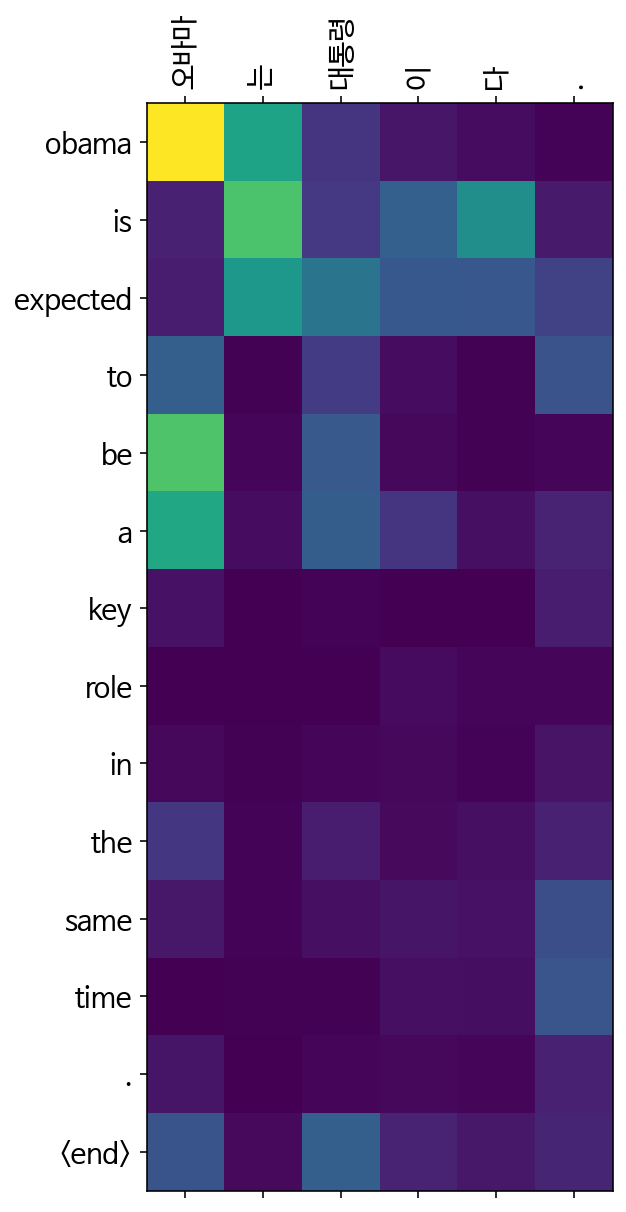

In [58]:
translate("오바마는 대통령이다.", encoder, decoder)

Input: ['시민', '들', '은', '도시', '속', '에', '산다', '.']
Predicted translation: they fear the locals are also a day . <end> 


/tmp/ipykernel_261/2013980603.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_261/2013980603.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


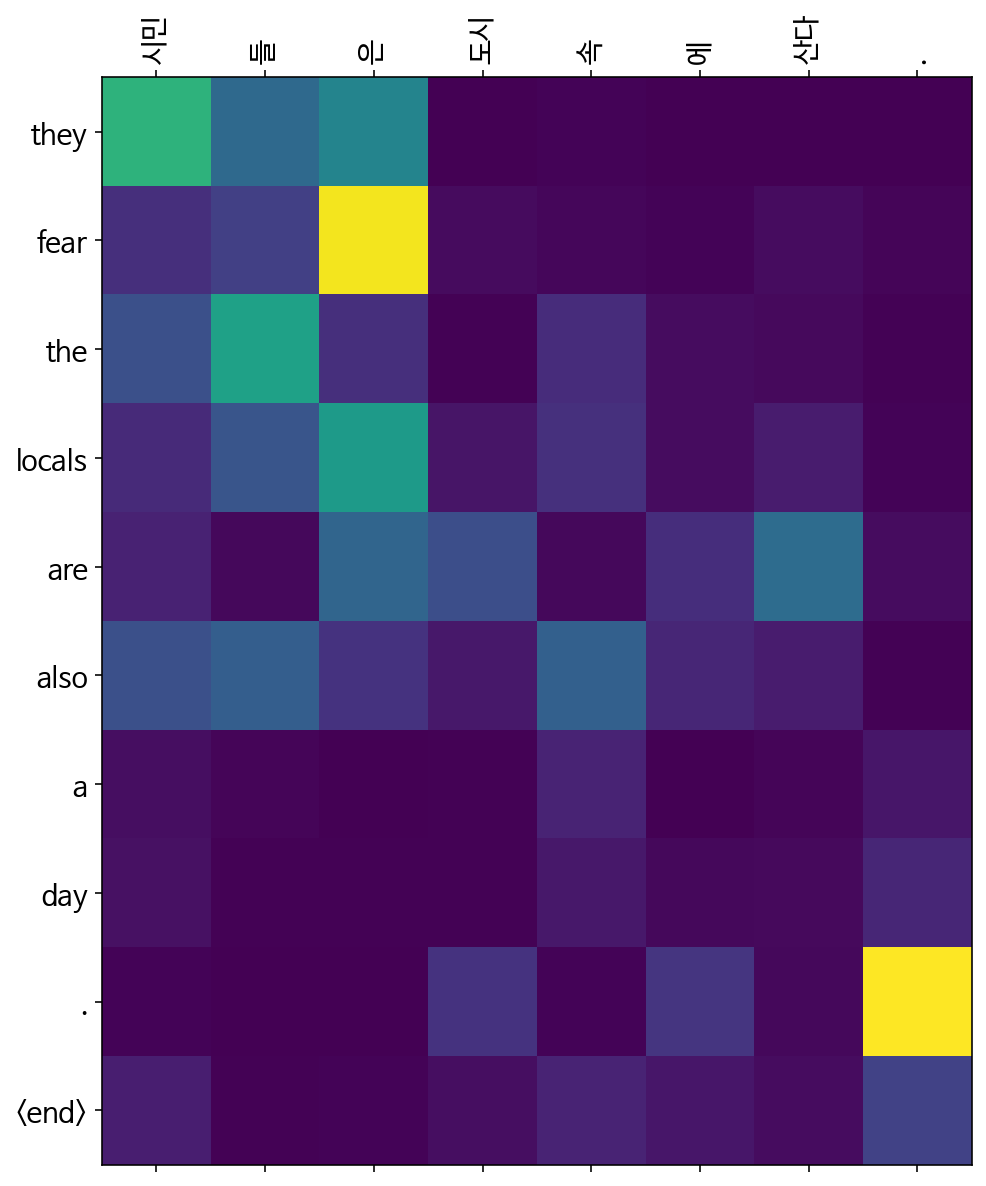

In [59]:
translate("시민들은 도시 속에 산다.", encoder, decoder)

Input: ['커피', '는', '필요', '없', '다', '.']
Predicted translation: it s not going to be unknowingly sabotaging your eyes . <end> 


/tmp/ipykernel_261/2013980603.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_261/2013980603.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


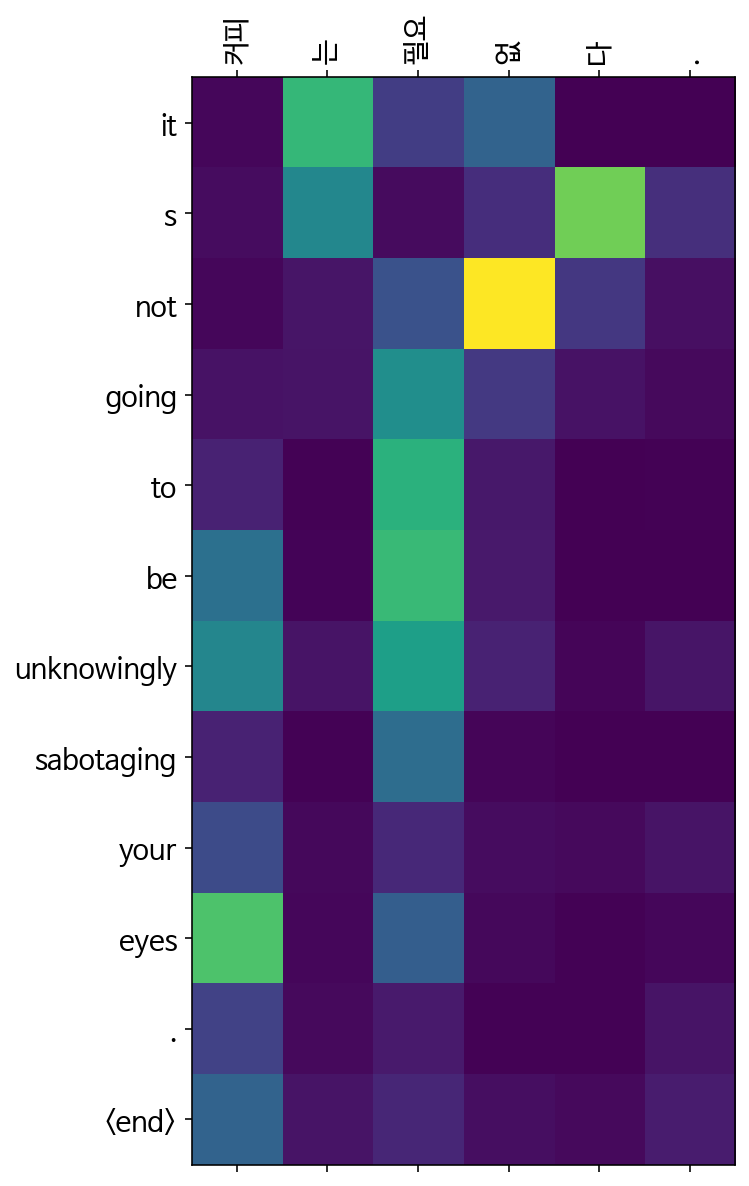

In [60]:
translate("커피는 필요 없다.", encoder, decoder)

Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다', '.']
Predicted translation: the death toll was killed . <end> 


/tmp/ipykernel_261/2013980603.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_261/2013980603.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


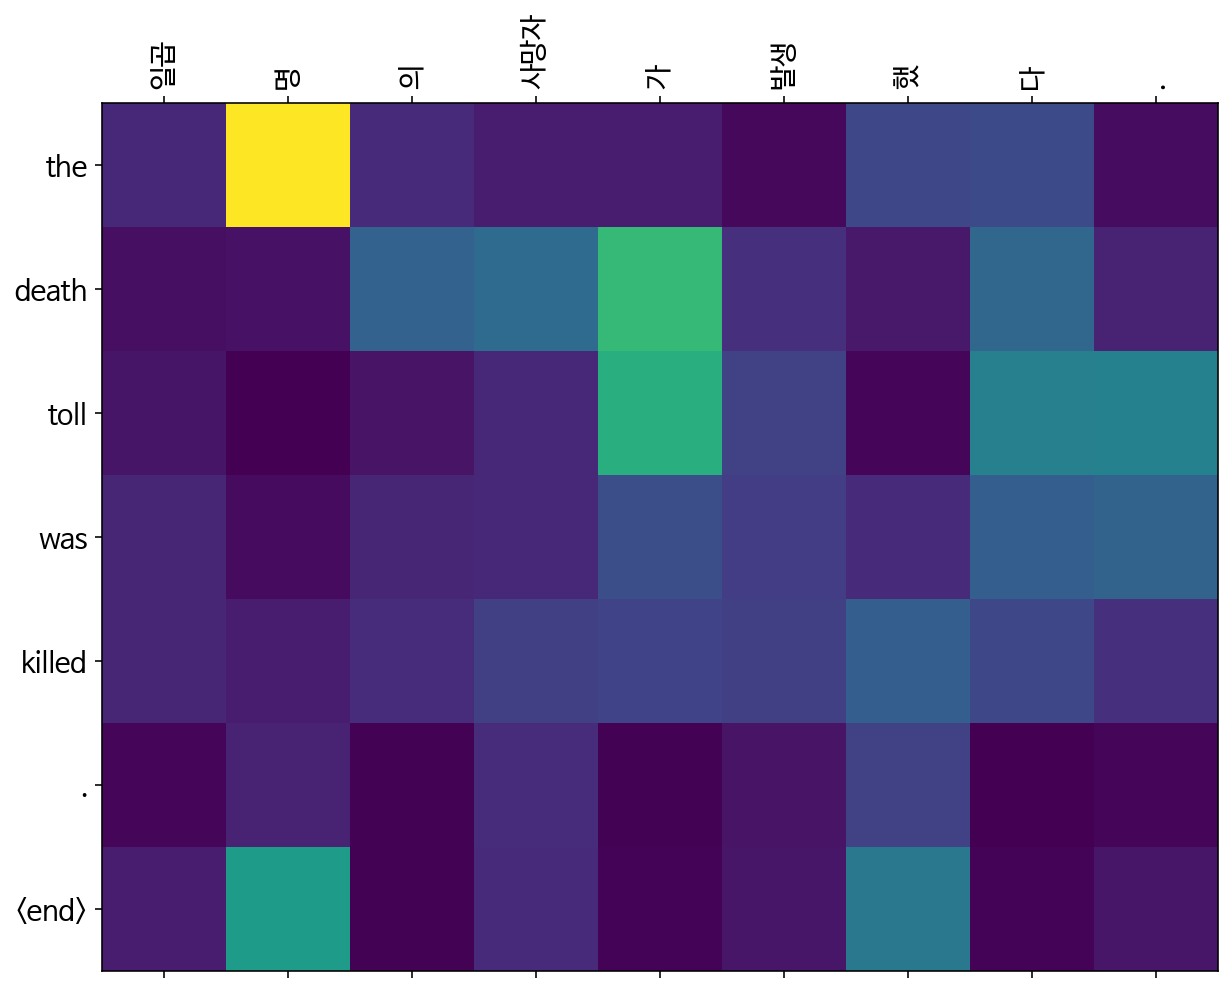

In [61]:
translate("일곱 명의 사망자가 발생했다.", encoder, decoder)

Input: ['경찰', '이', '범인', '을', '수사', '중', '이', '다', '.']
Predicted translation: police are investigating the police . <end> 


/tmp/ipykernel_261/2013980603.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_261/2013980603.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


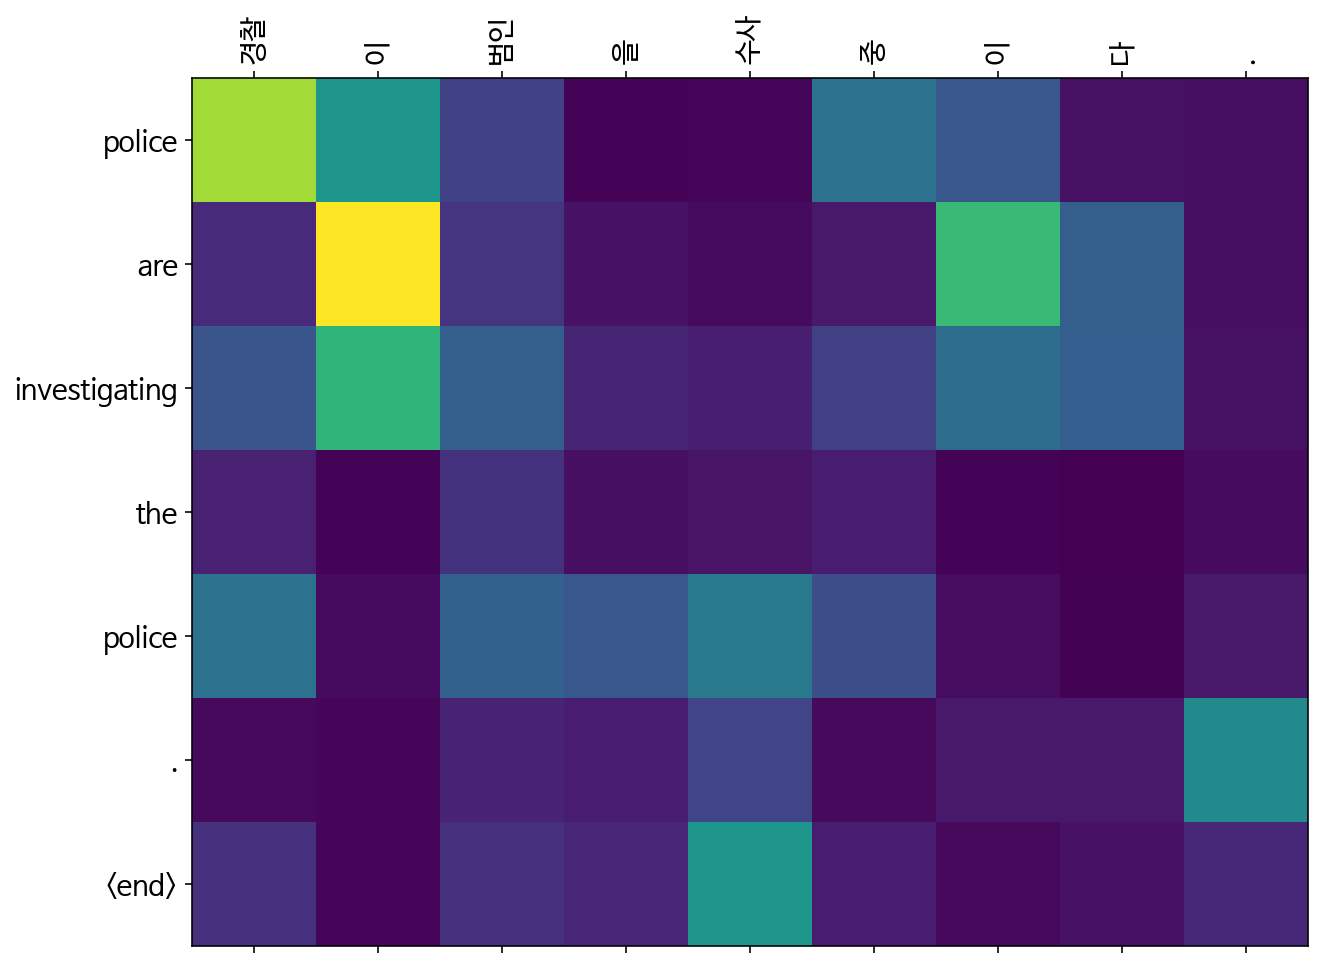

In [62]:
translate("경찰이 범인을 수사중이다.", encoder, decoder)

Input: ['일본', '과', '북한', '의', '외교관', '들', '이', '외교', '관계', '를', '정상', '화', '하', '려는', '회담', '을', '재개', '했', '다', '.']
Predicted translation: japan and north korean envoy to north korea . <end> 


/tmp/ipykernel_261/2013980603.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_261/2013980603.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


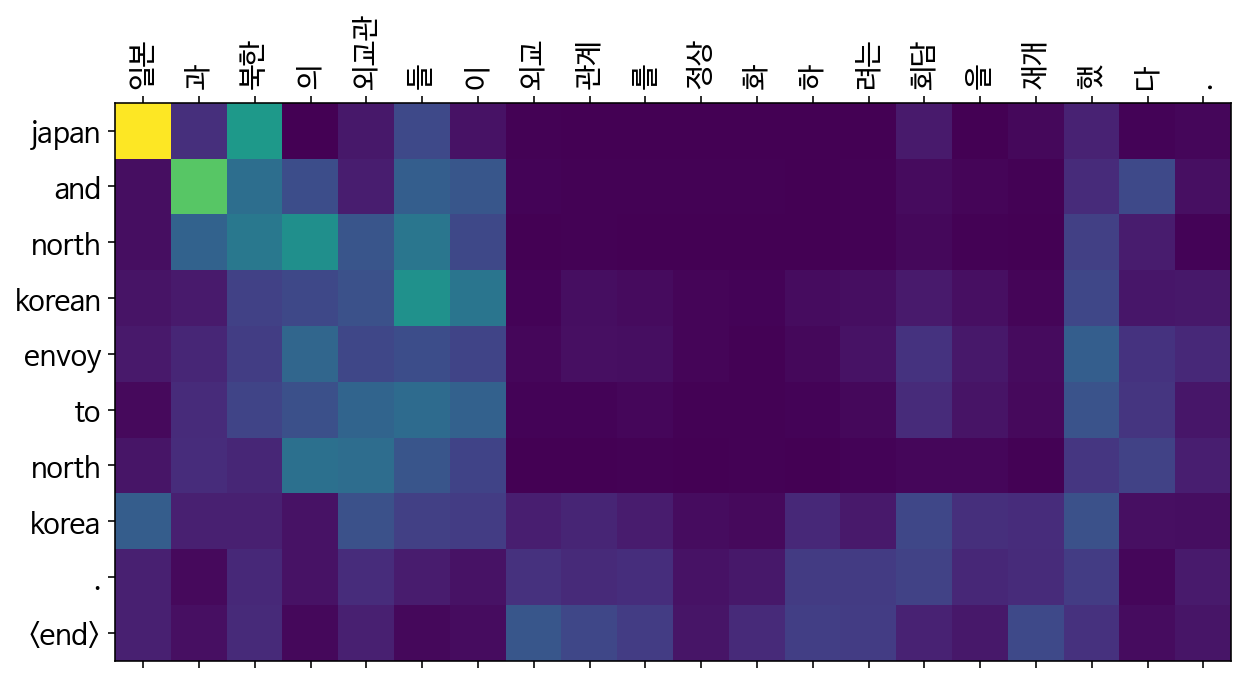

In [64]:
translate("일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.", encoder, decoder)

### 1. num_words 20000, epoch 15
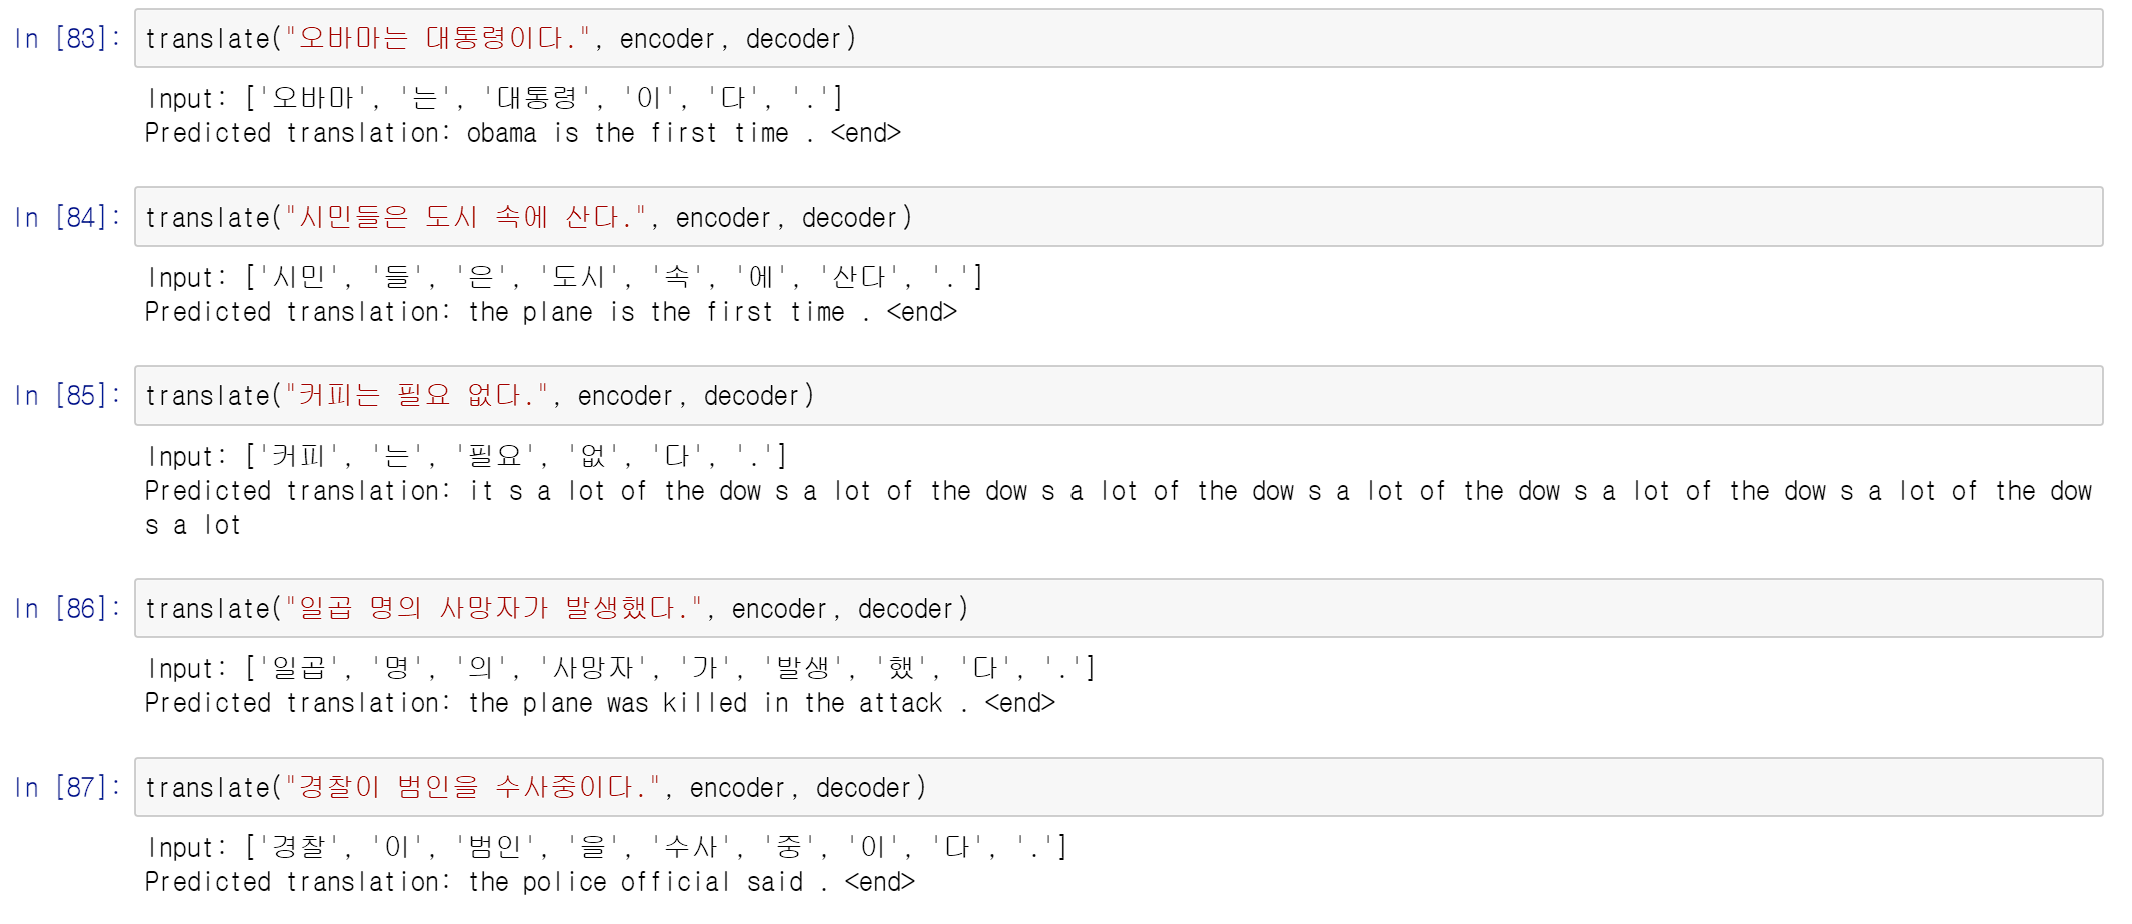

### 3. num_words = 30000, epoch = 15, loss = 2.9787
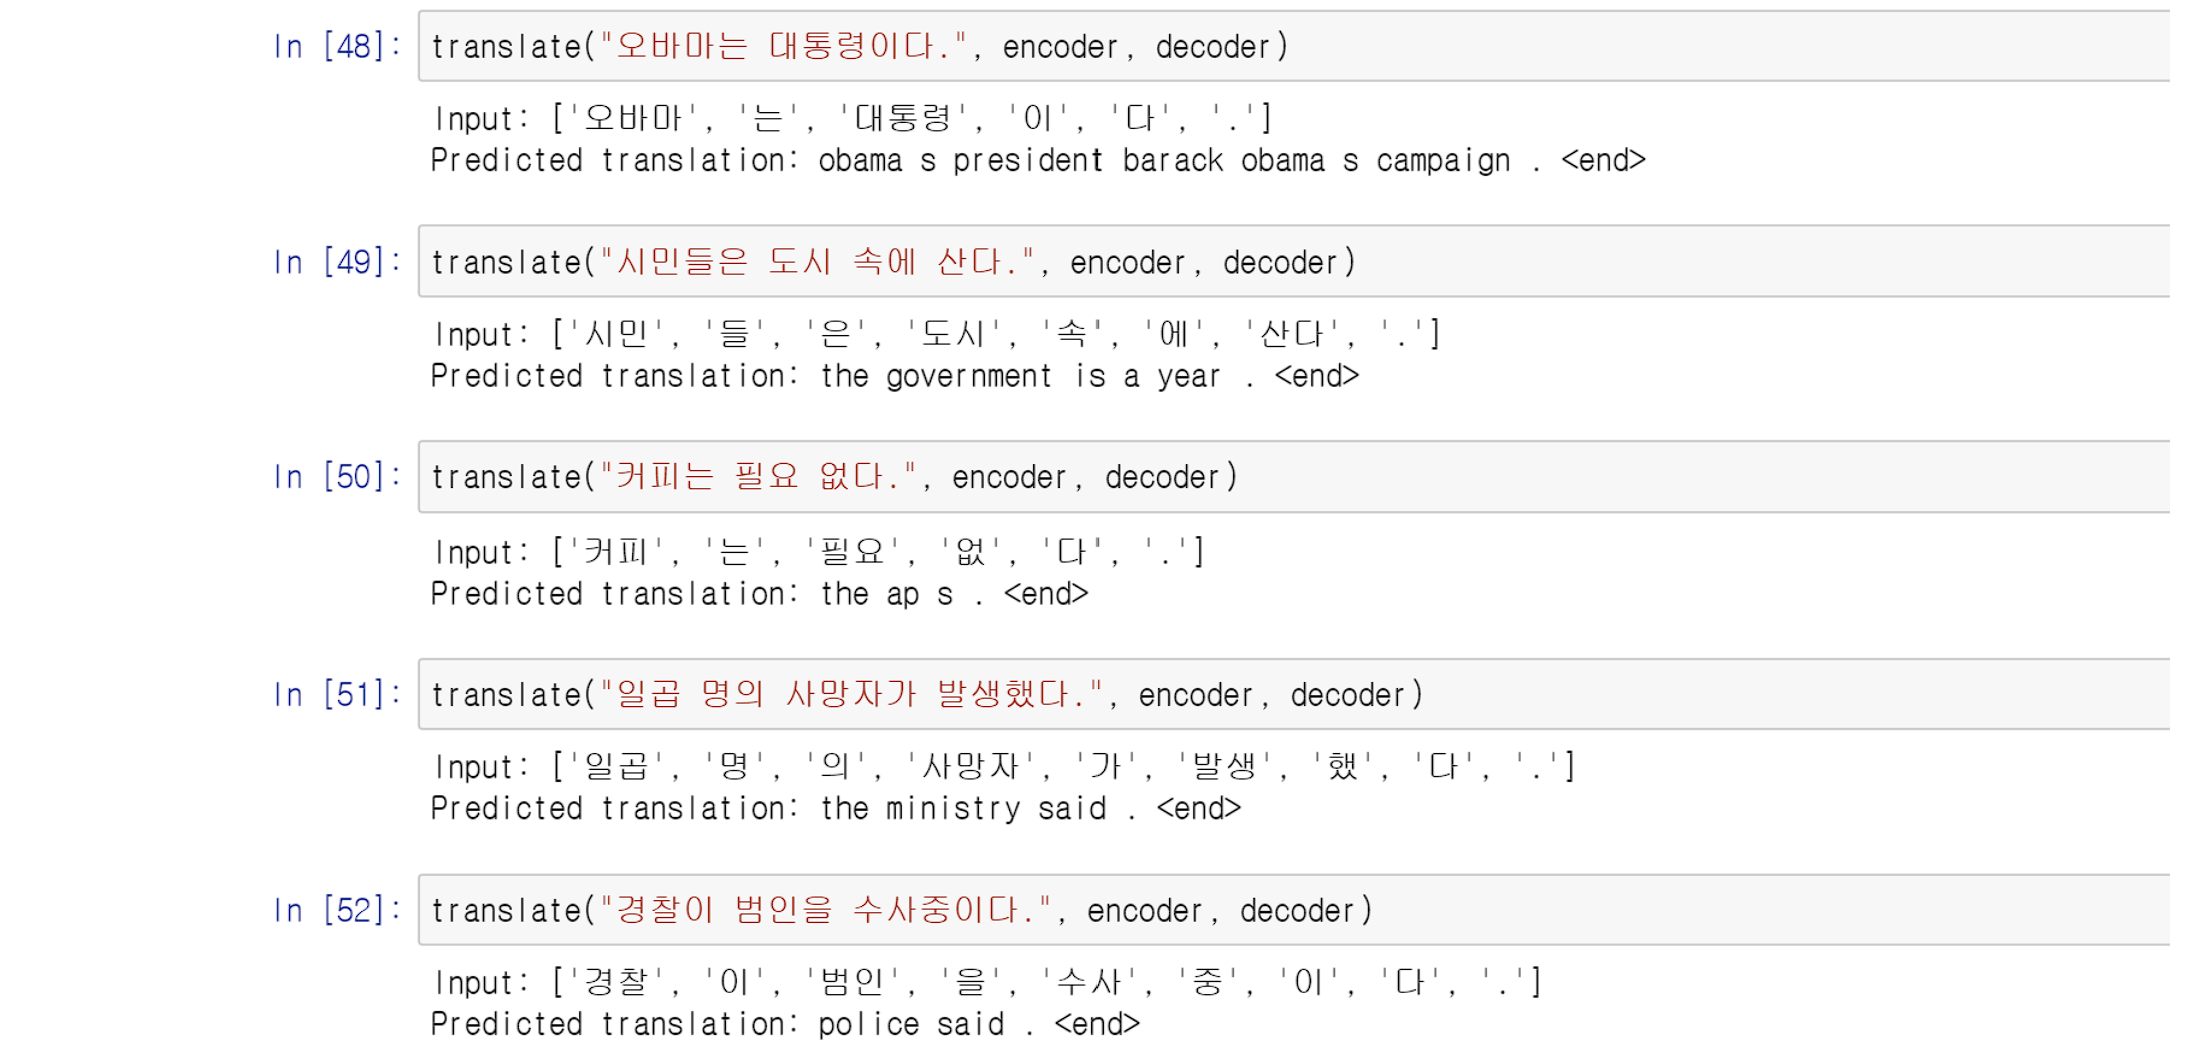

### 4. num_words 30000, epoch 30, loss 3.7735

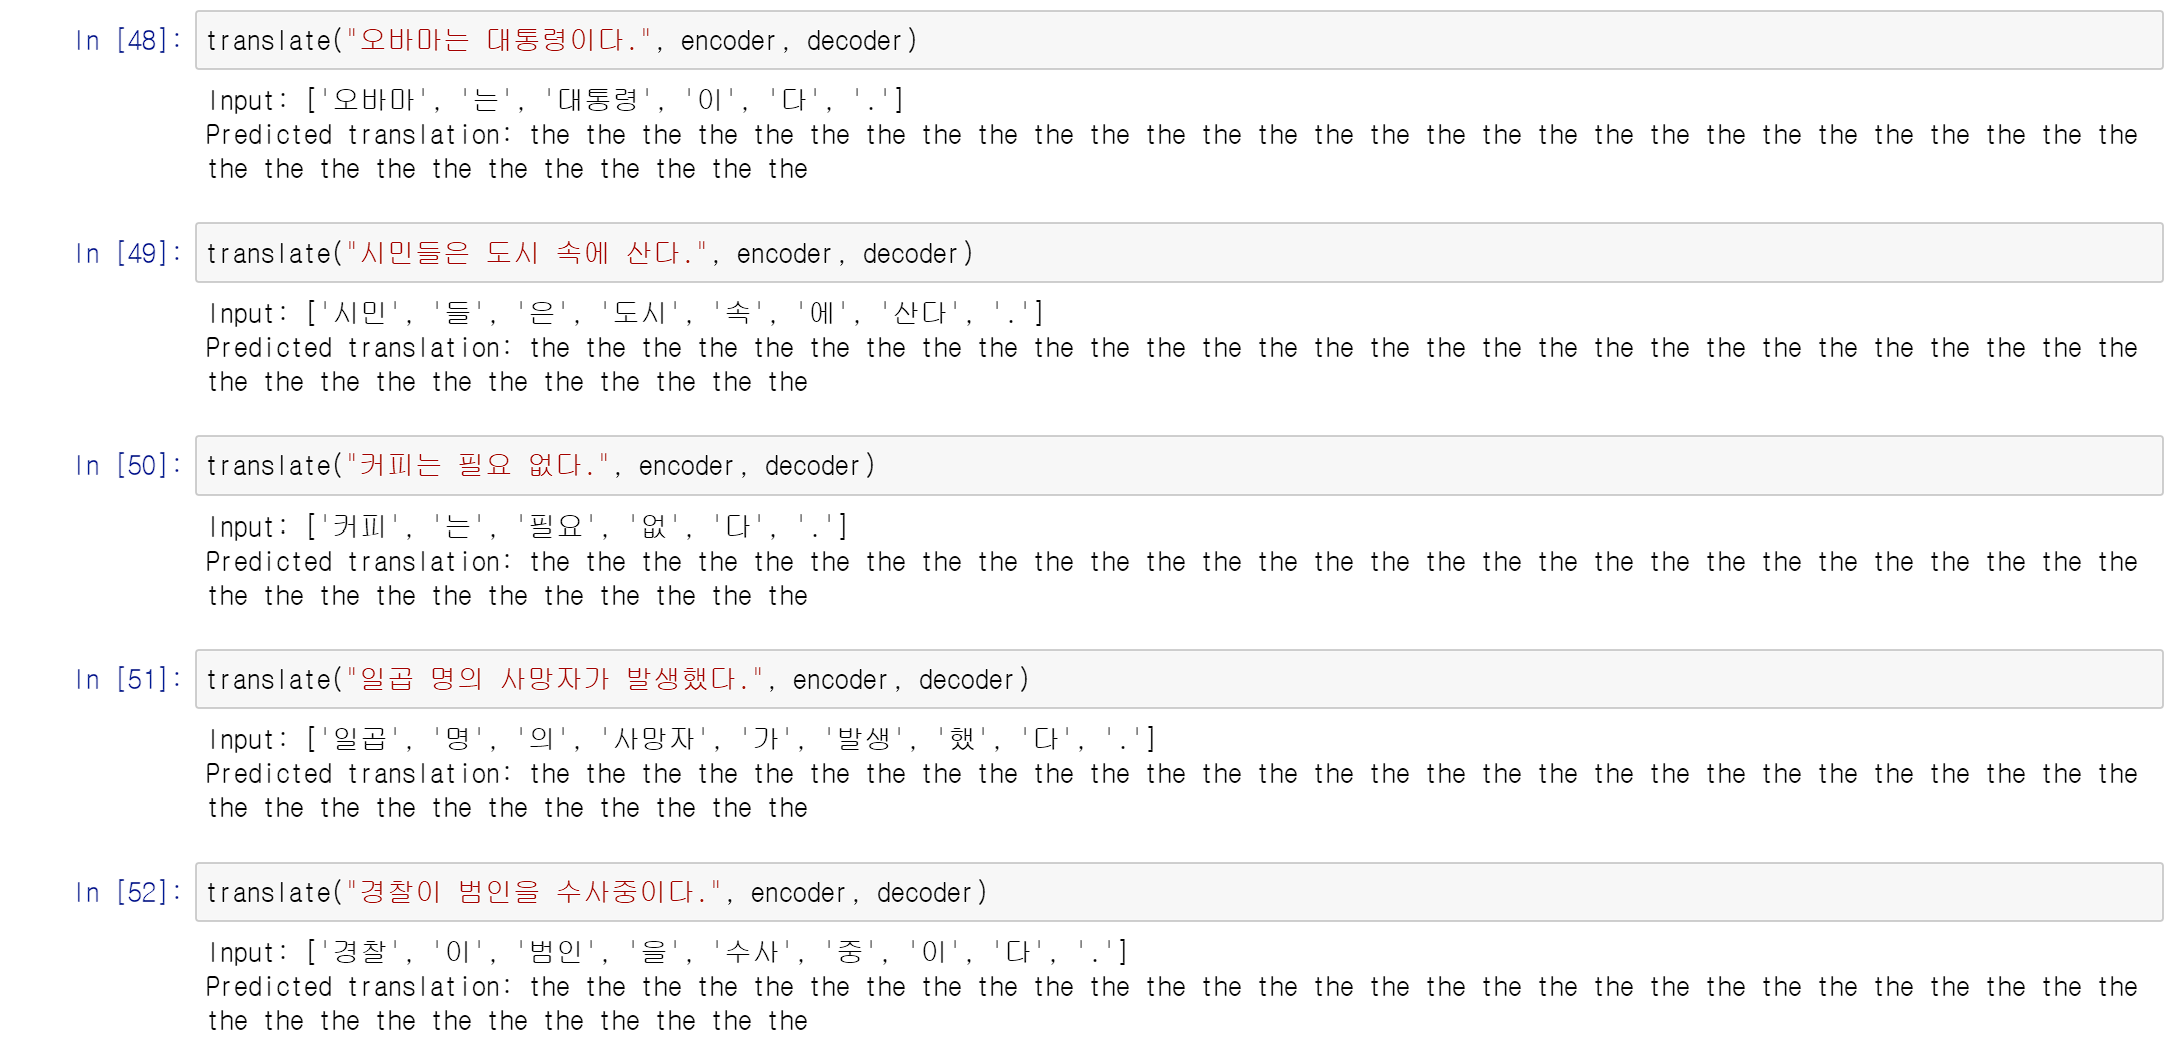

### 결론

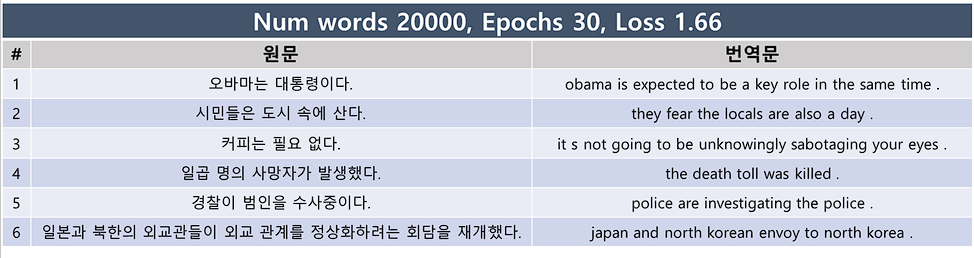



* best 모델의 번역 성능은 위 표와 같다.
* 번역 성능이 우수하지는 않지만, 오바마(obama), 사망자(death toll), 경찰(police), 일본(Japan), 북한(NorthKorea) 등 각 문장의 몇몇 핵심어는 옳게 번역이 된 모습을 보인다.
* 두 세 번째 글은 연관된 단어가 전혀 없이 번역 되었다.
* 위 실험 결과는 고려한 단어수가 많다고 해서 성능 향상으로 직결되는게 아니며, 다양한 양질의 문장을 가지고 충분히 학습을 진행했을 때 성능에 영향이 있음 시사한다.

### 이해한 것 정리 및 회고

* 해당 프로젝트에서는 두 개의 RNN 모듈을 Encoder-Decoder 구조로 결합한 Sequence-to-Sequence 모델 구조를 사용해 기계번역에 적용했다.
* 이때, 인코더의 마지막 hidden state 값(입력 문장을 요약한 고정 벡터) 만을 디코더에 제공하는 방식이 아닌, 인코더의 모든 hidden state 값을 디코더에 제공함으로써 디코더에서 번역을 진행할 때 해당 단어 생성에 관련성(중요도)가 높은 키워드를 참고할 수 있도록 했다. 이때 참고한 키워드가 encoder의 각 hidden state 값이다.<br>
<br>
* Encoder는 임베딩층과 GRU 층을 거치며, 'return_sequences=True'로 지정하여 마지막 hidden_state만 결과로 반환하지 않고 모든 sequence의 hidden_state를 반환한다. 이는 이후에 attention 메커니즘을 적용하기 위함이다.
* Decoder는 학습 시 Bahdanau Attention 메커니즘을 통해 도출된 __컨텍스트벡터__ 를 활용해 다음 단어를 생성한다.
* Decoder는 임베딩 층을 거친 후, Bahdanau Attention을 통해 생성된 컨텍스트벡터와 합쳐진 상태로 gru 층을 거쳐 디코더의 hidden_state(컨텍스트 벡터 생성에 사용)와 결과를 반환한다. 이때 컨텍스트 벡터를 함께 사용함으로써 문맥 정보를 유연하게 반영할 수 있도록 하였다.
* Bahdanau Attention 메커니즘은 다음과 같다.
    1. decoder의 첫 번째 hidden state와 encoder의 모든 hidden state 값을 요소합한뒤 tanh 함수를 거쳐 attention score를 얻음. (score를 얻는 방식은 다양하나, 여기에서는 요소합을 사용함.)
    2. 이후 softmax 함수를 거쳐 attention 가중치 생성. 이는 인코더의 어떤 단어(hidden state)가 디코더에서 다음 단어 생성 시 중요한 정보인지 알려주는 이정표 역할을 함.
    3. 이 이정표를 인코더의 모든 hidden_state와 곱해줌으로써 중요 단어를 마킹. (위에서는 키워드라고 언급)
    4. 이후 모든 벡터를 합해 컨텍스트 벡터를 생성.
    5. 컨텍스트 벡터를 디코더에 전달<br>
<br>
* attention map을 시각화 함으로써 학습 시 입력문장의 어떤 단어가 출력 문장의 어떤 단어와 매칭이 되었는지 확인할 수 있다.
* 하나의 예제를 살펴보면, 경찰과 police, 이와 are이 강한 상관관계로 매칭이 된 것을 볼 수 있다.
* 영어와 한글의 어순이 다른 탓에 매칭에 어려움이 있었던 것으로 보인다.

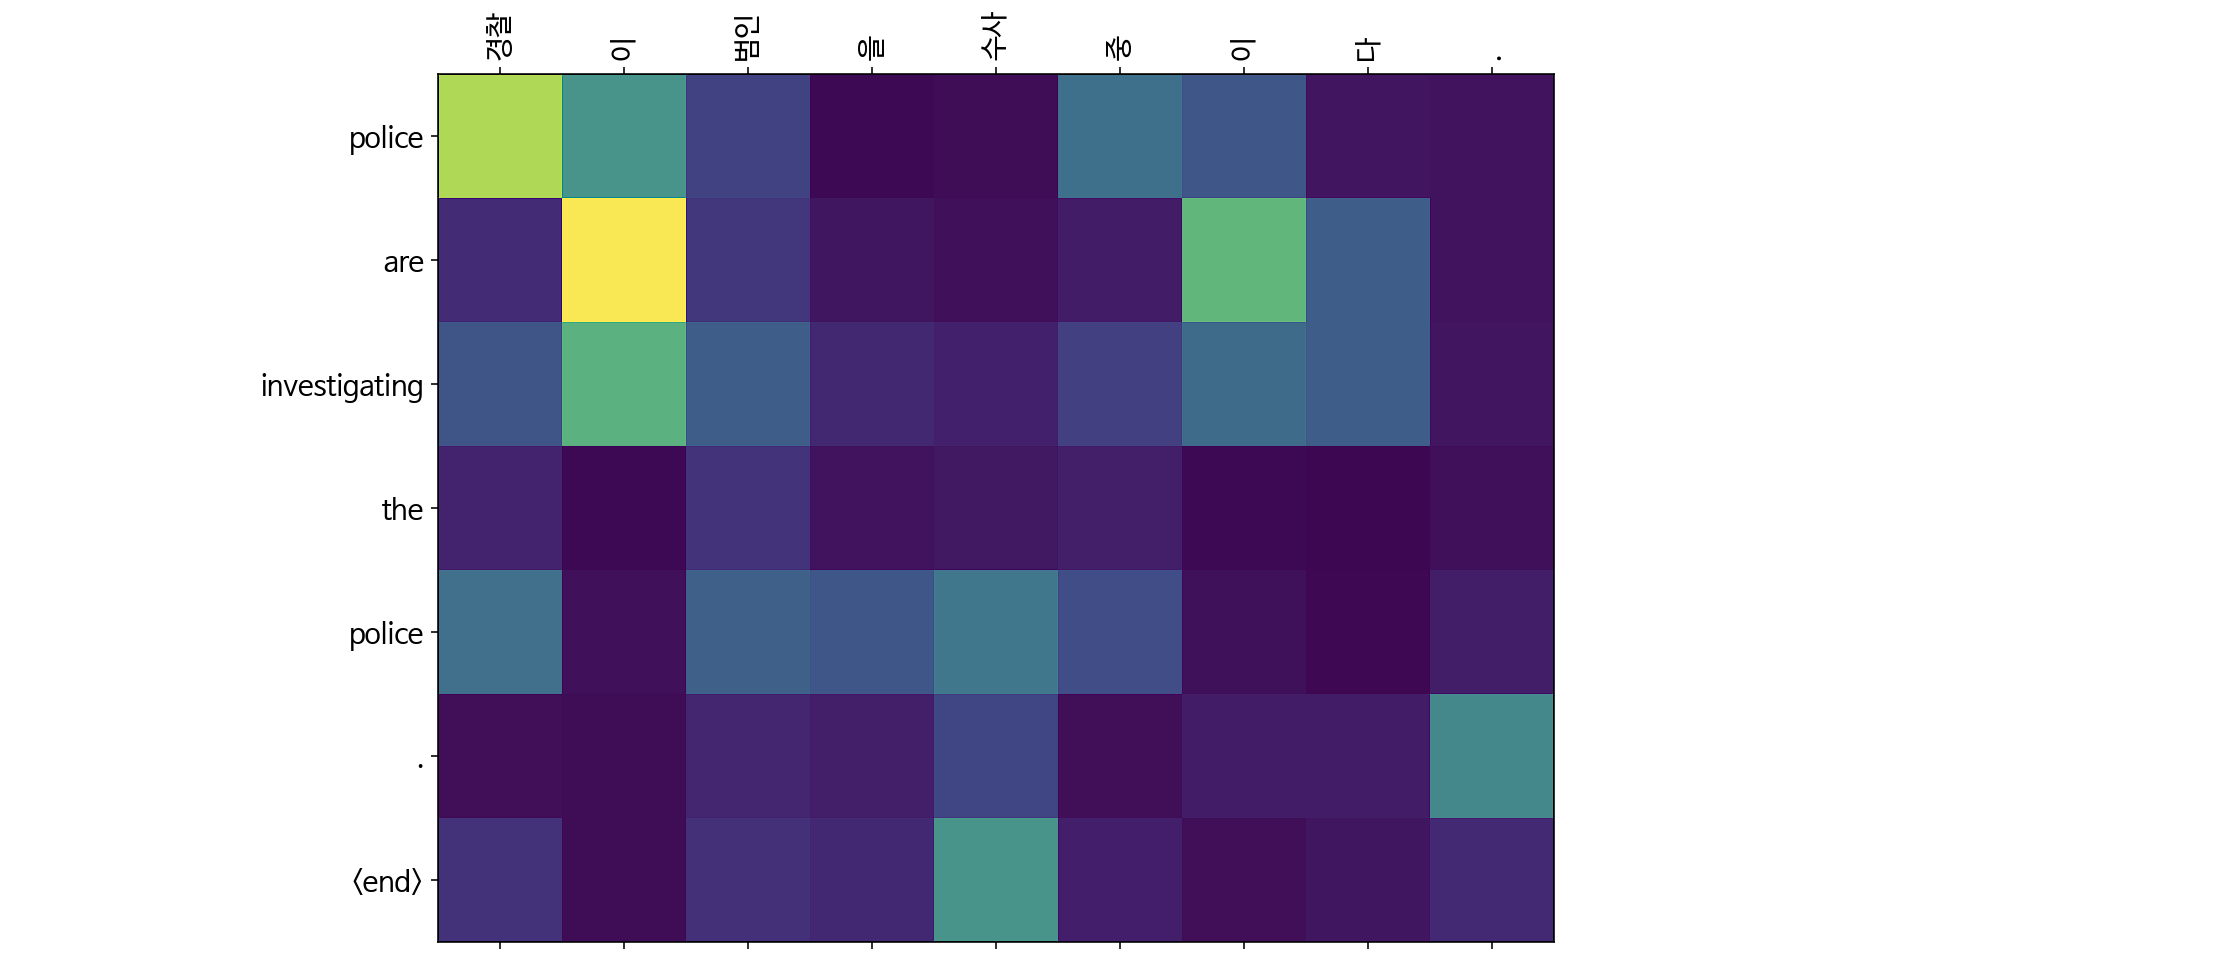
<br>